In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset , DataLoader , random_split
from torchvision.datasets import FashionMNIST

In [2]:
device = torch.device('cuda' if torch.cuda.is_available () else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [3]:
SEED = 42
set_seed(SEED)

train_dataset = FashionMNIST('./data',
    train=True ,
    download=True ,
    transform=transforms.ToTensor ())

test_dataset = FashionMNIST('./data',
    train=False ,
    download=True ,
    transform=transforms.ToTensor ())

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 1.52MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset , val_subset = random_split(train_dataset , [train_size , val_size ])

batch_size = 64

train_loader = DataLoader(train_subset , batch_size=batch_size , shuffle= True)
val_loader = DataLoader(val_subset , batch_size=batch_size , shuffle=False)
test_loader = DataLoader(test_dataset , batch_size=batch_size , shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 54000
Validation size: 6000
Test size: 10000


## Baseline model

In [ ]:
class MLP(nn.Module):
    def __init__(self , input_dims , hidden_dims , output_dims):
        super(MLP , self).__init__ ()
        self.layer1 = nn.Linear(input_dims , hidden_dims)
        self.layer2 = nn.Linear(hidden_dims , hidden_dims)
        self.layer3 = nn.Linear(hidden_dims , hidden_dims)
        self.layer4 = nn.Linear(hidden_dims , hidden_dims)
        self.layer5 = nn.Linear(hidden_dims , hidden_dims)
        self.layer6 = nn.Linear(hidden_dims , hidden_dims)
        self.layer7 = nn.Linear(hidden_dims , hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)

    def forward(self , x):
        x = nn.Flatten ()(x)
        x = self.layer1(x)
        x = nn.Sigmoid ()(x)
        x = self.layer2(x)
        x = nn.Sigmoid ()(x)
        x = self.layer3(x)
        x = nn.Sigmoid ()(x)
        x = self.layer4(x)
        x = nn.Sigmoid ()(x)
        x = self.layer5(x)
        x = nn.Sigmoid ()(x)
        x = self.layer6(x)
        x = nn.Sigmoid ()(x)
        x = self.layer7(x)
        x = nn.Sigmoid ()(x)
        out = self.output(x)
        return out

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims ,
    hidden_dims=hidden_dims ,
    output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss ()
optimizer = optim.SGD(model.parameters (), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train , y_train in train_loader:
        X_train , y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad ()
        outputs = model(X_train)
        loss = criterion(outputs , y_train)
        loss.backward ()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs , 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad ():
        for X_val , y_val in val_loader:
            X_val , y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs , y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs , 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch +1}/{ epochs}, Train_Loss: {train_loss :.4f}, Train_Acc: {train_acc :.4f}, Validation Loss: {val_loss :.4f}, Val_Acc: {val_acc :.4f}")

EPOCH 1/100, Train_Loss: 2.3039, Train_Acc: 0.0984, Validation Loss: 2.3048, Val_Acc: 0.1020
EPOCH 2/100, Train_Loss: 2.3039, Train_Acc: 0.0995, Validation Loss: 2.3036, Val_Acc: 0.0997
EPOCH 3/100, Train_Loss: 2.3038, Train_Acc: 0.0988, Validation Loss: 2.3042, Val_Acc: 0.1020
EPOCH 4/100, Train_Loss: 2.3039, Train_Acc: 0.0999, Validation Loss: 2.3040, Val_Acc: 0.0937
EPOCH 5/100, Train_Loss: 2.3039, Train_Acc: 0.0994, Validation Loss: 2.3036, Val_Acc: 0.1018
EPOCH 6/100, Train_Loss: 2.3039, Train_Acc: 0.0990, Validation Loss: 2.3024, Val_Acc: 0.1022
EPOCH 7/100, Train_Loss: 2.3039, Train_Acc: 0.1000, Validation Loss: 2.3034, Val_Acc: 0.1022
EPOCH 8/100, Train_Loss: 2.3038, Train_Acc: 0.1020, Validation Loss: 2.3049, Val_Acc: 0.1000
EPOCH 9/100, Train_Loss: 2.3039, Train_Acc: 0.0981, Validation Loss: 2.3039, Val_Acc: 0.1012
EPOCH 10/100, Train_Loss: 2.3038, Train_Acc: 0.1001, Validation Loss: 2.3057, Val_Acc: 0.1000
EPOCH 11/100, Train_Loss: 2.3039, Train_Acc: 0.1013, Validation Loss:

Text(0.5, 1.0, 'Validation Accuracy')

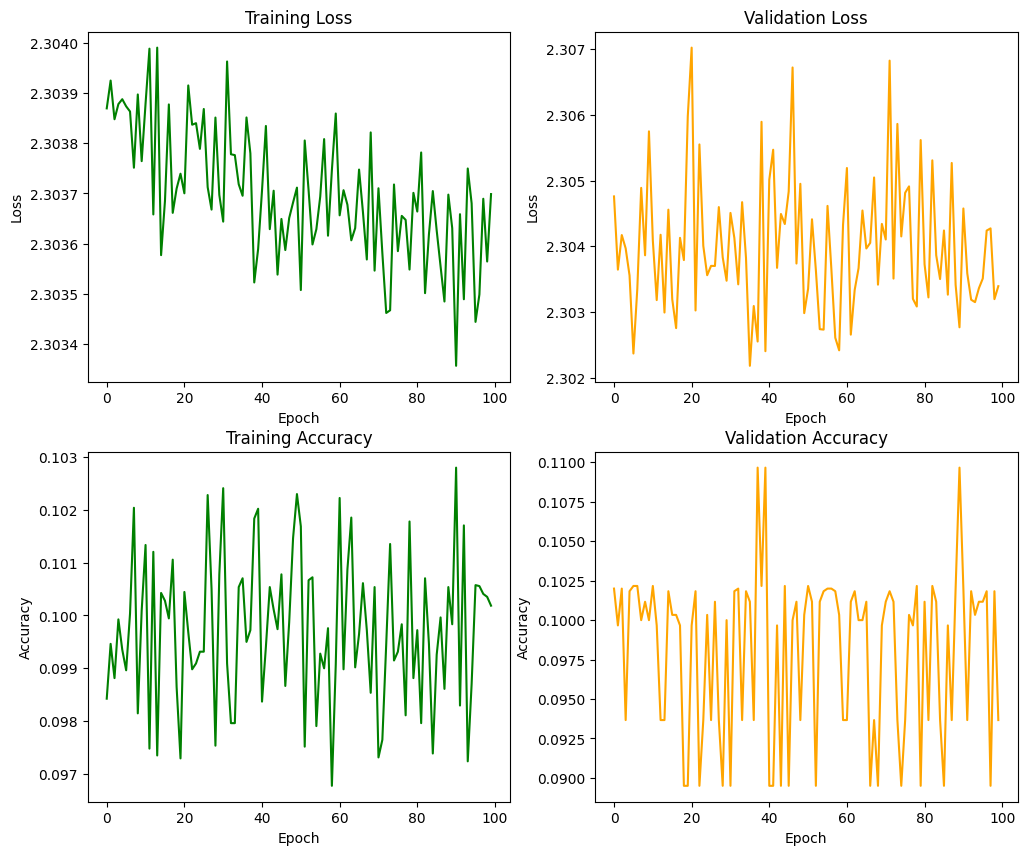

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

## Weight Increasing

In [ ]:
class MLP(nn.Module):
    def __init__(self , input_dims , hidden_dims , output_dims):
        super(MLP , self).__init__ ()
        self.layer1 = nn.Linear(input_dims , hidden_dims)
        self.layer2 = nn.Linear(hidden_dims , hidden_dims)
        self.layer3 = nn.Linear(hidden_dims , hidden_dims)
        self.layer4 = nn.Linear(hidden_dims , hidden_dims)
        self.layer5 = nn.Linear(hidden_dims , hidden_dims)
        self.layer6 = nn.Linear(hidden_dims , hidden_dims)
        self.layer7 = nn.Linear(hidden_dims , hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)

        for module in self.modules():
          if isinstance(module, nn.Linear ):
            nn.init.normal_ (module.weight, mean =0.0, std =1.0)
            nn.init.constant_(module.bias, 0.0)

    def forward(self , x):
        x = nn.Flatten ()(x)
        x = self.layer1(x)
        x = nn.Sigmoid ()(x)
        x = self.layer2(x)
        x = nn.Sigmoid ()(x)
        x = self.layer3(x)
        x = nn.Sigmoid ()(x)
        x = self.layer4(x)
        x = nn.Sigmoid ()(x)
        x = self.layer5(x)
        x = nn.Sigmoid ()(x)
        x = self.layer6(x)
        x = nn.Sigmoid ()(x)
        x = self.layer7(x)
        x = nn.Sigmoid ()(x)
        out = self.output(x)
        return out

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims ,
    hidden_dims=hidden_dims ,
    output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss ()
optimizer = optim.SGD(model.parameters (), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train , y_train in train_loader:
        X_train , y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad ()
        outputs = model(X_train)
        loss = criterion(outputs , y_train)
        loss.backward ()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs , 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad ():
        for X_val , y_val in val_loader:
            X_val , y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs , y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs , 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch +1}/{ epochs}, Train_Loss: {train_loss :.4f}, Train_Acc: {train_acc :.4f}, Validation Loss: {val_loss :.4f}, Val_Acc: {val_acc :.4f}")

EPOCH 1/100, Train_Loss: 1.9086, Train_Acc: 0.3811, Validation Loss: 1.3838, Val_Acc: 0.4938
EPOCH 2/100, Train_Loss: 1.2365, Train_Acc: 0.5449, Validation Loss: 1.1712, Val_Acc: 0.5670
EPOCH 3/100, Train_Loss: 1.0792, Train_Acc: 0.5993, Validation Loss: 1.0621, Val_Acc: 0.6073
EPOCH 4/100, Train_Loss: 0.9875, Train_Acc: 0.6314, Validation Loss: 0.9931, Val_Acc: 0.6260
EPOCH 5/100, Train_Loss: 0.9253, Train_Acc: 0.6512, Validation Loss: 0.9407, Val_Acc: 0.6503
EPOCH 6/100, Train_Loss: 0.8801, Train_Acc: 0.6691, Validation Loss: 0.9058, Val_Acc: 0.6628
EPOCH 7/100, Train_Loss: 0.8451, Train_Acc: 0.6825, Validation Loss: 0.8757, Val_Acc: 0.6743
EPOCH 8/100, Train_Loss: 0.8164, Train_Acc: 0.6920, Validation Loss: 0.8527, Val_Acc: 0.6867
EPOCH 9/100, Train_Loss: 0.7929, Train_Acc: 0.7020, Validation Loss: 0.8343, Val_Acc: 0.6928
EPOCH 10/100, Train_Loss: 0.7723, Train_Acc: 0.7097, Validation Loss: 0.8140, Val_Acc: 0.7027
EPOCH 11/100, Train_Loss: 0.7547, Train_Acc: 0.7159, Validation Loss:

Text(0.5, 1.0, 'Validation Accuracy')

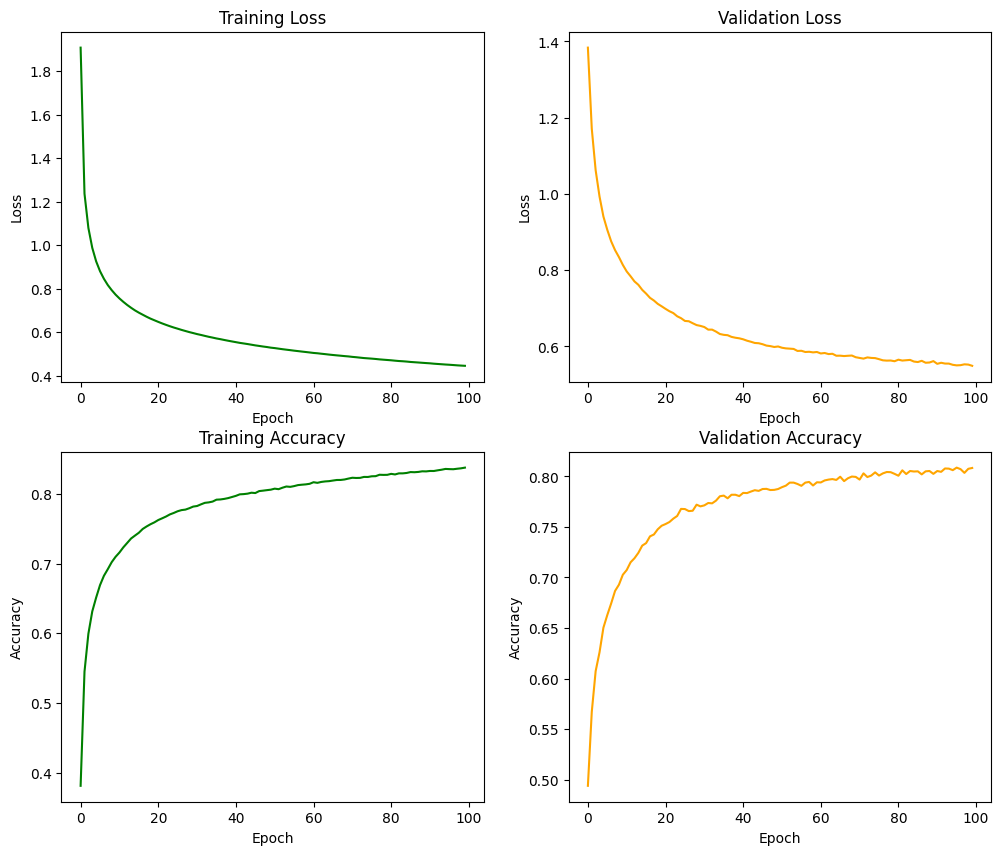

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

## Better Activation

In [ ]:
class MLP(nn.Module):
    def __init__(self , input_dims , hidden_dims , output_dims):
        super(MLP , self).__init__ ()
        self.layer1 = nn.Linear(input_dims , hidden_dims)
        self.layer2 = nn.Linear(hidden_dims , hidden_dims)
        self.layer3 = nn.Linear(hidden_dims , hidden_dims)
        self.layer4 = nn.Linear(hidden_dims , hidden_dims)
        self.layer5 = nn.Linear(hidden_dims , hidden_dims)
        self.layer6 = nn.Linear(hidden_dims , hidden_dims)
        self.layer7 = nn.Linear(hidden_dims , hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)

        for module in self.modules():
          if isinstance(module, nn.Linear ):
            nn.init.normal_ (module.weight, mean =0.0, std =0.05)
            nn.init.constant_(module.bias, 0.0)

    def forward(self , x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        out = self.output(x)
        return out

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims ,
    hidden_dims=hidden_dims ,
    output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss ()
optimizer = optim.SGD(model.parameters (), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train , y_train in train_loader:
        X_train , y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad ()
        outputs = model(X_train)
        loss = criterion(outputs , y_train)
        loss.backward ()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs , 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad ():
        for X_val , y_val in val_loader:
            X_val , y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs , y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs , 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch +1}/{ epochs}, Train_Loss: {train_loss :.4f}, Train_Acc: {train_acc :.4f}, Validation Loss: {val_loss :.4f}, Val_Acc: {val_acc :.4f}")

EPOCH 1/100, Train_Loss: 2.3018, Train_Acc: 0.1303, Validation Loss: 2.3015, Val_Acc: 0.1772
EPOCH 2/100, Train_Loss: 2.3005, Train_Acc: 0.1356, Validation Loss: 2.2998, Val_Acc: 0.1637
EPOCH 3/100, Train_Loss: 2.2973, Train_Acc: 0.2263, Validation Loss: 2.2939, Val_Acc: 0.2097
EPOCH 4/100, Train_Loss: 2.2757, Train_Acc: 0.2870, Validation Loss: 2.2227, Val_Acc: 0.3023
EPOCH 5/100, Train_Loss: 1.6053, Train_Acc: 0.3778, Validation Loss: 1.3116, Val_Acc: 0.4740
EPOCH 6/100, Train_Loss: 1.0882, Train_Acc: 0.5405, Validation Loss: 0.9856, Val_Acc: 0.5837
EPOCH 7/100, Train_Loss: 0.9635, Train_Acc: 0.6047, Validation Loss: 0.8957, Val_Acc: 0.6662
EPOCH 8/100, Train_Loss: 0.8861, Train_Acc: 0.6568, Validation Loss: 1.1218, Val_Acc: 0.5545
EPOCH 9/100, Train_Loss: 0.8142, Train_Acc: 0.6957, Validation Loss: 0.7680, Val_Acc: 0.7265
EPOCH 10/100, Train_Loss: 0.7383, Train_Acc: 0.7276, Validation Loss: 0.8192, Val_Acc: 0.6770
EPOCH 11/100, Train_Loss: 0.6719, Train_Acc: 0.7515, Validation Loss:

Text(0.5, 1.0, 'Validation Accuracy')

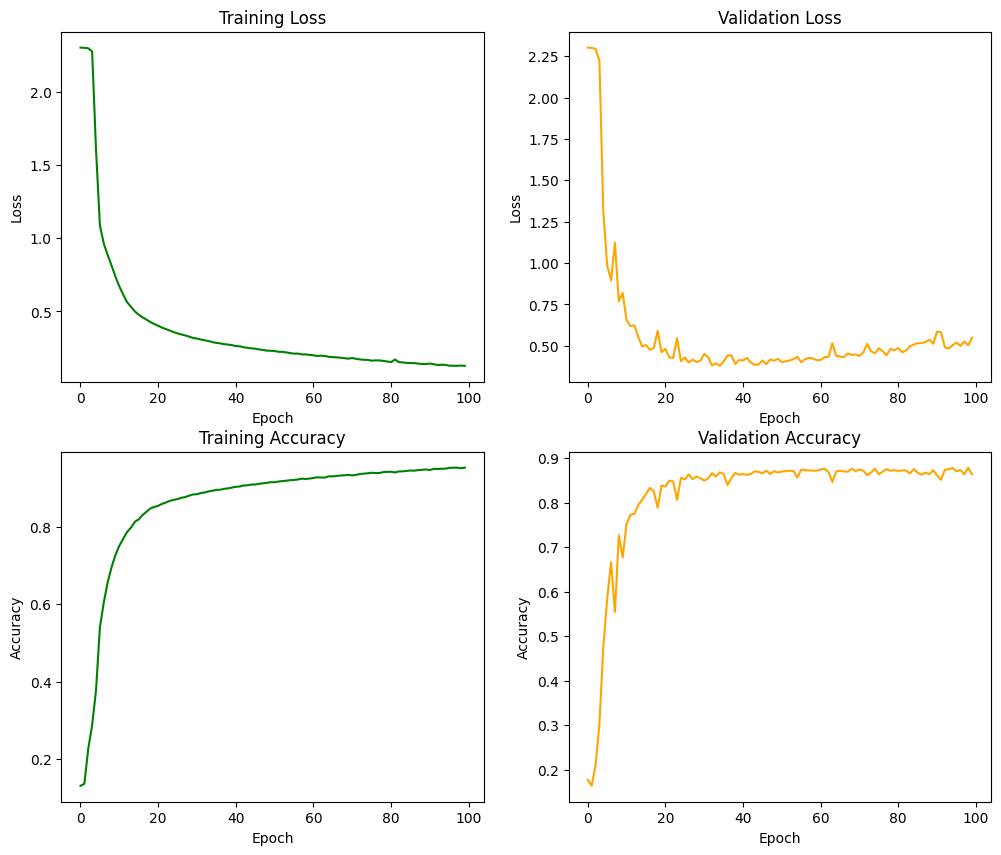

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

## Better Optimizer

In [ ]:
class MLP(nn.Module):
    def __init__(self , input_dims , hidden_dims , output_dims):
        super(MLP , self).__init__ ()
        self.layer1 = nn.Linear(input_dims , hidden_dims)
        self.layer2 = nn.Linear(hidden_dims , hidden_dims)
        self.layer3 = nn.Linear(hidden_dims , hidden_dims)
        self.layer4 = nn.Linear(hidden_dims , hidden_dims)
        self.layer5 = nn.Linear(hidden_dims , hidden_dims)
        self.layer6 = nn.Linear(hidden_dims , hidden_dims)
        self.layer7 = nn.Linear(hidden_dims , hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)

        for module in self.modules():
          if isinstance(module, nn.Linear ):
            nn.init.normal_ (module.weight, mean =0.0, std =0.05)
            nn.init.constant_(module.bias, 0.0)

    def forward(self , x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        out = self.output(x)
        return out

In [ ]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-3

model = MLP(input_dims=input_dims ,
    hidden_dims=hidden_dims ,
    output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss ()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train , y_train in train_loader:
        X_train , y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad ()
        outputs = model(X_train)
        loss = criterion(outputs , y_train)
        loss.backward ()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs , 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad ():
        for X_val , y_val in val_loader:
            X_val , y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs , y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs , 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch +1}/{ epochs}, Train_Loss: {train_loss :.4f}, Train_Acc: {train_acc :.4f}, Validation Loss: {val_loss :.4f}, Val_Acc: {val_acc :.4f}")

EPOCH 1/100, Train_Loss: 0.8075, Train_Acc: 0.6823, Validation Loss: 0.5760, Val_Acc: 0.7798
EPOCH 2/100, Train_Loss: 0.4928, Train_Acc: 0.8146, Validation Loss: 0.4972, Val_Acc: 0.8153
EPOCH 3/100, Train_Loss: 0.4231, Train_Acc: 0.8490, Validation Loss: 0.4435, Val_Acc: 0.8550
EPOCH 4/100, Train_Loss: 0.3778, Train_Acc: 0.8661, Validation Loss: 0.3882, Val_Acc: 0.8603
EPOCH 5/100, Train_Loss: 0.3442, Train_Acc: 0.8776, Validation Loss: 0.3746, Val_Acc: 0.8638
EPOCH 6/100, Train_Loss: 0.3244, Train_Acc: 0.8810, Validation Loss: 0.3453, Val_Acc: 0.8765
EPOCH 7/100, Train_Loss: 0.3083, Train_Acc: 0.8888, Validation Loss: 0.3607, Val_Acc: 0.8762
EPOCH 8/100, Train_Loss: 0.2980, Train_Acc: 0.8924, Validation Loss: 0.3390, Val_Acc: 0.8823
EPOCH 9/100, Train_Loss: 0.2835, Train_Acc: 0.8970, Validation Loss: 0.3349, Val_Acc: 0.8785
EPOCH 10/100, Train_Loss: 0.2751, Train_Acc: 0.9007, Validation Loss: 0.3284, Val_Acc: 0.8842
EPOCH 11/100, Train_Loss: 0.2635, Train_Acc: 0.9048, Validation Loss:

Text(0.5, 1.0, 'Validation Accuracy')

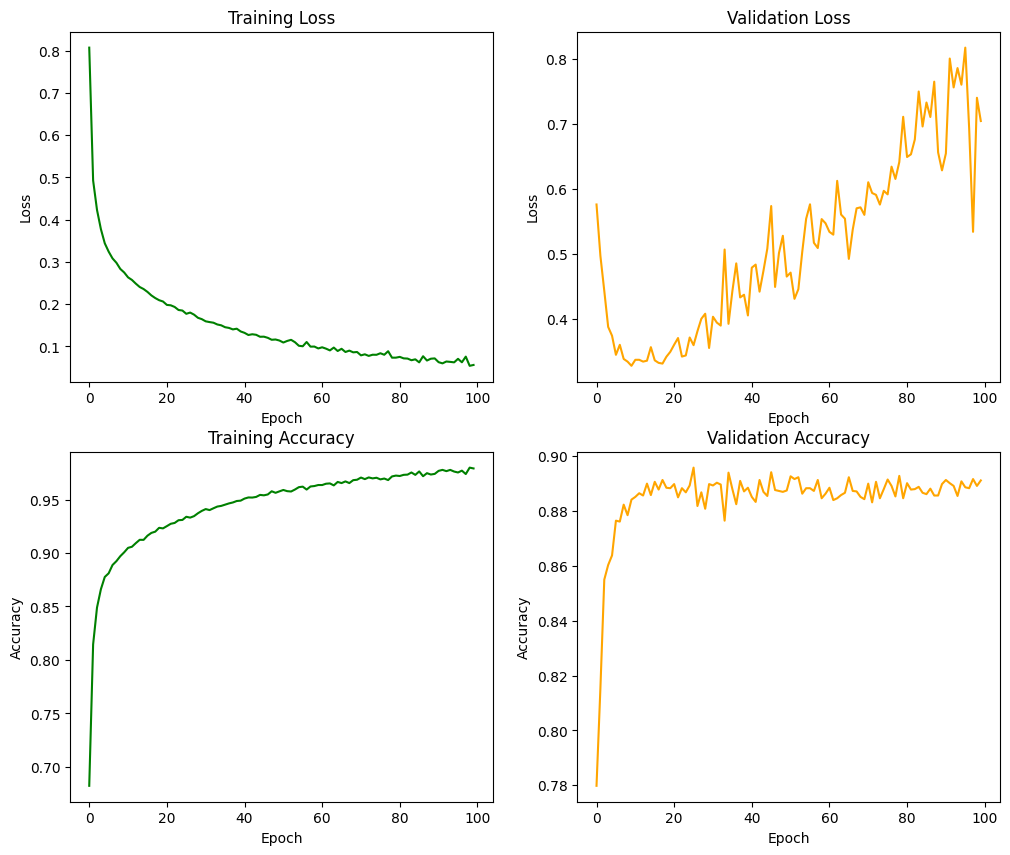

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

## Normalize Inside Network

In [40]:
class MLP(nn.Module):
    def __init__(self , input_dims , hidden_dims , output_dims):
        super(MLP , self).__init__ ()
        self.layer1 = nn.Linear(input_dims , hidden_dims)
        self.layer2 = nn.Linear(hidden_dims , hidden_dims)
        self.layer3 = nn.Linear(hidden_dims , hidden_dims)
        self.layer4 = nn.Linear(hidden_dims , hidden_dims)
        self.layer5 = nn.Linear(hidden_dims , hidden_dims)
        self.layer6 = nn.Linear(hidden_dims , hidden_dims)
        self.layer7 = nn.Linear(hidden_dims , hidden_dims)
        self.hidden_dims = hidden_dims
        self.batch_norm = nn.BatchNorm1d(hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)

        for module in self.modules():
          if isinstance(module, nn.Linear ):
            nn.init.normal_ (module.weight, mean =0.0, std =0.05)
            nn.init.constant_(module.bias, 0.0)



    def forward(self , x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.batch_norm(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = self.batch_norm(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = self.batch_norm(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = self.batch_norm(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = self.batch_norm(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = self.batch_norm(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = self.batch_norm(x)
        x = nn.ReLU()(x)
        out = self.output(x)
        return out

In [41]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-4

model = MLP(input_dims=input_dims ,
    hidden_dims=hidden_dims ,
    output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss ()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [42]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train , y_train in train_loader:
        X_train , y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad ()
        outputs = model(X_train)
        loss = criterion(outputs , y_train)
        loss.backward ()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs , 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad ():
        for X_val , y_val in val_loader:
            X_val , y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs , y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs , 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch +1}/{ epochs}, Train_Loss: {train_loss :.4f}, Train_Acc: {train_acc :.4f}, Validation Loss: {val_loss :.4f}, Val_Acc: {val_acc :.4f}")

EPOCH 1/100, Train_Loss: 0.8024, Train_Acc: 0.7589, Validation Loss: 1.5836, Val_Acc: 0.5550
EPOCH 2/100, Train_Loss: 0.4432, Train_Acc: 0.8484, Validation Loss: 1.3751, Val_Acc: 0.6208
EPOCH 3/100, Train_Loss: 0.3798, Train_Acc: 0.8660, Validation Loss: 1.2751, Val_Acc: 0.5925
EPOCH 4/100, Train_Loss: 0.3414, Train_Acc: 0.8789, Validation Loss: 1.1007, Val_Acc: 0.6763
EPOCH 5/100, Train_Loss: 0.3152, Train_Acc: 0.8866, Validation Loss: 1.1198, Val_Acc: 0.6545
EPOCH 6/100, Train_Loss: 0.2967, Train_Acc: 0.8921, Validation Loss: 1.1312, Val_Acc: 0.6207
EPOCH 7/100, Train_Loss: 0.2770, Train_Acc: 0.8993, Validation Loss: 1.0235, Val_Acc: 0.6753
EPOCH 8/100, Train_Loss: 0.2636, Train_Acc: 0.9032, Validation Loss: 0.9971, Val_Acc: 0.6788
EPOCH 9/100, Train_Loss: 0.2500, Train_Acc: 0.9081, Validation Loss: 0.9907, Val_Acc: 0.6530
EPOCH 10/100, Train_Loss: 0.2368, Train_Acc: 0.9133, Validation Loss: 0.9947, Val_Acc: 0.6458
EPOCH 11/100, Train_Loss: 0.2257, Train_Acc: 0.9170, Validation Loss:

Text(0.5, 1.0, 'Validation Accuracy')

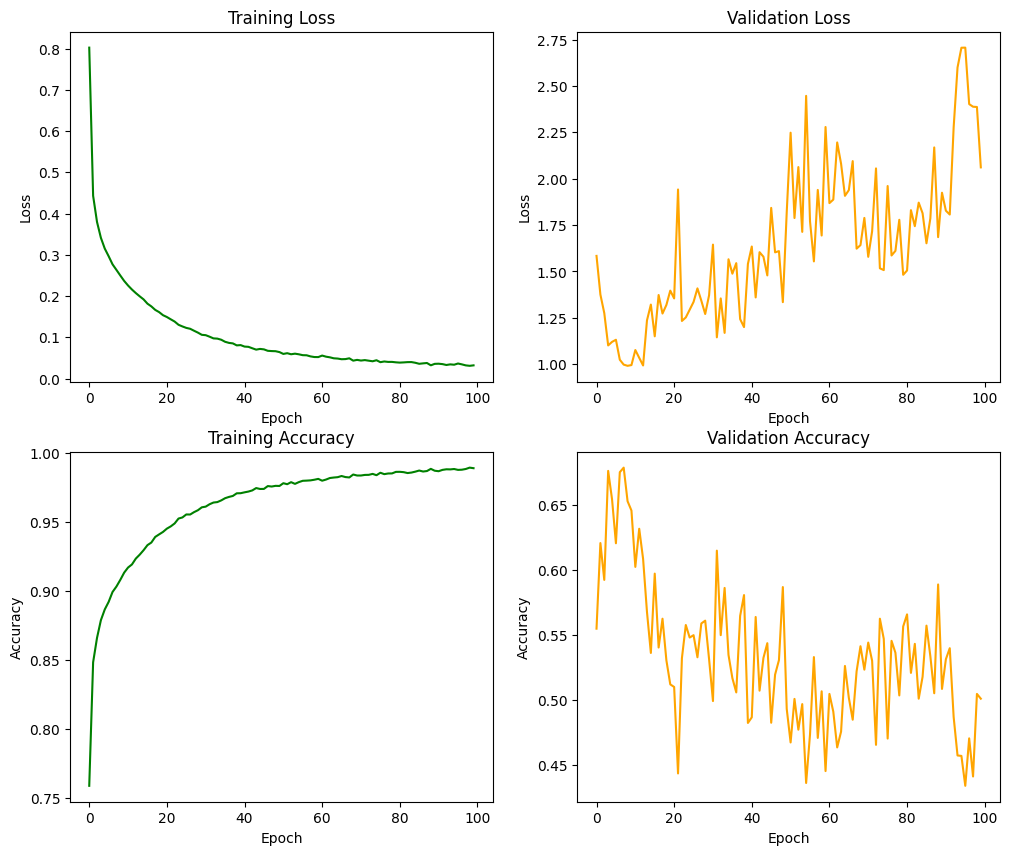

In [43]:
fig, ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

## Skip Connection

In [22]:
class MLP(nn.Module):
    def __init__(self , input_dims , hidden_dims , output_dims):
        super(MLP , self).__init__ ()
        self.layer1 = nn.Linear(input_dims , hidden_dims)
        self.layer2 = nn.Linear(hidden_dims , hidden_dims)
        self.layer3 = nn.Linear(hidden_dims , hidden_dims)
        self.layer4 = nn.Linear(hidden_dims , hidden_dims)
        self.layer5 = nn.Linear(hidden_dims , hidden_dims)
        self.layer6 = nn.Linear(hidden_dims , hidden_dims)
        self.layer7 = nn.Linear(hidden_dims , hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)

        for module in self.modules():
          if isinstance(module, nn.Linear ):
            nn.init.normal_ (module.weight, mean =0.0, std =0.05)
            nn.init.constant_(module.bias, 0.0)

    def forward(self , x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        skip = x

        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = x + skip

        x = self.layer4(x)
        x = nn.ReLU()(x)
        skip = x

        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        x = x + skip

        out = self.output(x)
        return out

In [23]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-3

model = MLP(input_dims=input_dims ,
    hidden_dims=hidden_dims ,
    output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss ()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [24]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train , y_train in train_loader:
        X_train , y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad ()
        outputs = model(X_train)
        loss = criterion(outputs , y_train)
        loss.backward ()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs , 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad ():
        for X_val , y_val in val_loader:
            X_val , y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs , y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs , 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch +1}/{ epochs}, Train_Loss: {train_loss :.4f}, Train_Acc: {train_acc :.4f}, Validation Loss: {val_loss :.4f}, Val_Acc: {val_acc :.4f}")

EPOCH 1/100, Train_Loss: 0.5368, Train_Acc: 0.8062, Validation Loss: 0.4206, Val_Acc: 0.8480
EPOCH 2/100, Train_Loss: 0.3764, Train_Acc: 0.8619, Validation Loss: 0.3620, Val_Acc: 0.8652
EPOCH 3/100, Train_Loss: 0.3386, Train_Acc: 0.8749, Validation Loss: 0.3623, Val_Acc: 0.8703
EPOCH 4/100, Train_Loss: 0.3142, Train_Acc: 0.8833, Validation Loss: 0.3301, Val_Acc: 0.8775
EPOCH 5/100, Train_Loss: 0.2933, Train_Acc: 0.8912, Validation Loss: 0.3759, Val_Acc: 0.8647
EPOCH 6/100, Train_Loss: 0.2793, Train_Acc: 0.8961, Validation Loss: 0.3229, Val_Acc: 0.8828
EPOCH 7/100, Train_Loss: 0.2635, Train_Acc: 0.9015, Validation Loss: 0.3090, Val_Acc: 0.8848
EPOCH 8/100, Train_Loss: 0.2540, Train_Acc: 0.9053, Validation Loss: 0.3612, Val_Acc: 0.8703
EPOCH 9/100, Train_Loss: 0.2424, Train_Acc: 0.9086, Validation Loss: 0.3585, Val_Acc: 0.8698
EPOCH 10/100, Train_Loss: 0.2319, Train_Acc: 0.9116, Validation Loss: 0.3296, Val_Acc: 0.8872
EPOCH 11/100, Train_Loss: 0.2238, Train_Acc: 0.9150, Validation Loss:

Text(0.5, 1.0, 'Validation Accuracy')

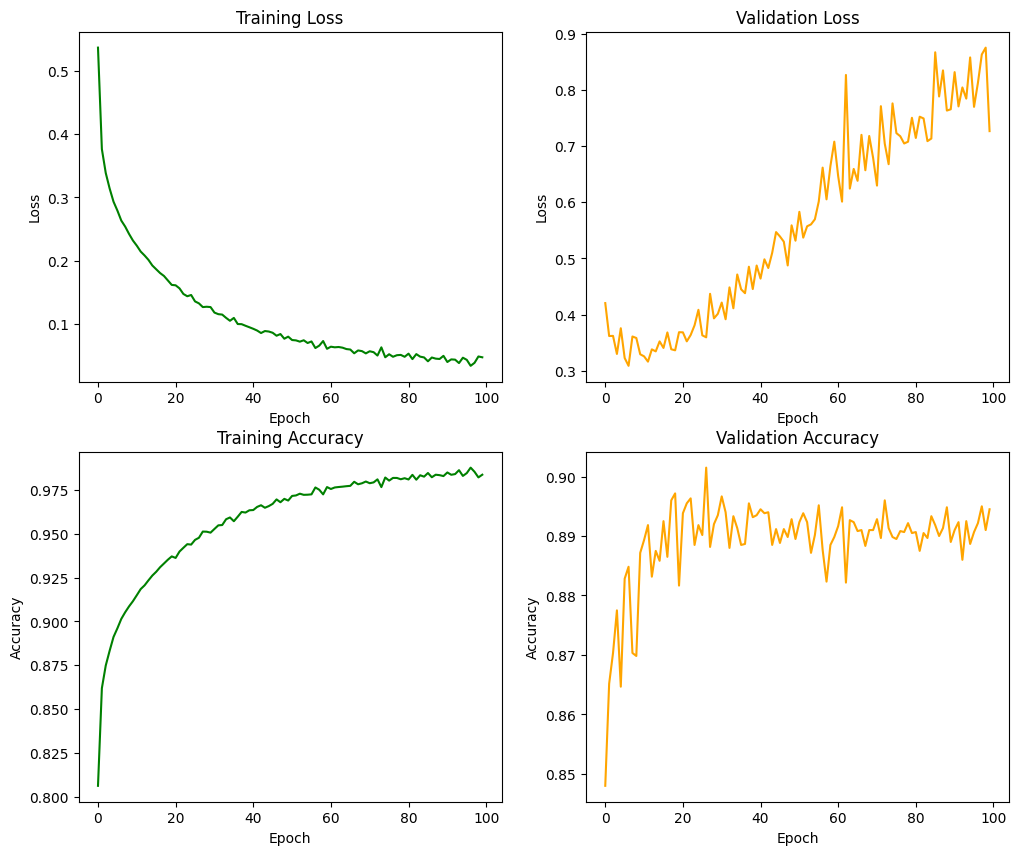

In [25]:
fig, ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

## Gradient Normalization

In [26]:
# Custom Gradient Normalization Layer
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass: pass input unchanged
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        # Normalize the gradient
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6) # Avoid division by zero
        return grad_input

# Wrapper Module for GradientNormalization
class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()

    def forward(self, x):
        return GradientNormalization.apply(x)

In [27]:
class MLP(nn.Module):
    def __init__(self , input_dims , hidden_dims , output_dims):
        super(MLP , self).__init__ ()
        self.layer1 = nn.Linear(input_dims , hidden_dims)
        self.layer2 = nn.Linear(hidden_dims , hidden_dims)
        self.layer3 = nn.Linear(hidden_dims , hidden_dims)
        self.layer4 = nn.Linear(hidden_dims , hidden_dims)
        self.layer5 = nn.Linear(hidden_dims , hidden_dims)
        self.layer6 = nn.Linear(hidden_dims , hidden_dims)
        self.layer7 = nn.Linear(hidden_dims , hidden_dims)
        self.output = nn.Linear(hidden_dims , output_dims)
        self.gradient_norm = GradientNormalizationLayer()

    def forward(self , x):
        x = nn.Flatten ()(x)
        x = self.layer1(x)
        x = self.gradient_norm(x)
        x = nn.Sigmoid ()(x)
        x = self.layer2(x)
        x = self.gradient_norm(x)
        x = nn.Sigmoid ()(x)
        x = self.layer3(x)
        x = self.gradient_norm(x)
        x = nn.Sigmoid ()(x)
        x = self.layer4(x)
        x = self.gradient_norm(x)
        x = nn.Sigmoid ()(x)
        x = self.layer5(x)
        x = self.gradient_norm(x)
        x = nn.Sigmoid ()(x)
        x = self.layer6(x)
        x = self.gradient_norm(x)
        x = nn.Sigmoid ()(x)
        x = self.layer7(x)
        x = self.gradient_norm(x)
        x = nn.Sigmoid ()(x)
        out = self.output(x)
        return out

In [28]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims ,
    hidden_dims=hidden_dims ,
    output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss ()
optimizer = optim.SGD(model.parameters (), lr=lr)

In [29]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train , y_train in train_loader:
        X_train , y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad ()
        outputs = model(X_train)
        loss = criterion(outputs , y_train)
        loss.backward ()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs , 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad ():
        for X_val , y_val in val_loader:
            X_val , y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs , y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs , 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch +1}/{ epochs}, Train_Loss: {train_loss :.4f}, Train_Acc: {train_acc :.4f}, Validation Loss: {val_loss :.4f}, Val_Acc: {val_acc :.4f}")

EPOCH 1/100, Train_Loss: 2.3060, Train_Acc: 0.0993, Validation Loss: 2.3107, Val_Acc: 0.0895
EPOCH 2/100, Train_Loss: 2.3051, Train_Acc: 0.0999, Validation Loss: 2.3060, Val_Acc: 0.1003
EPOCH 3/100, Train_Loss: 2.3050, Train_Acc: 0.1001, Validation Loss: 2.3069, Val_Acc: 0.1097
EPOCH 4/100, Train_Loss: 2.3051, Train_Acc: 0.1006, Validation Loss: 2.3062, Val_Acc: 0.1000
EPOCH 5/100, Train_Loss: 2.3052, Train_Acc: 0.0977, Validation Loss: 2.3037, Val_Acc: 0.0997
EPOCH 6/100, Train_Loss: 2.3049, Train_Acc: 0.1028, Validation Loss: 2.3062, Val_Acc: 0.1000
EPOCH 7/100, Train_Loss: 2.3048, Train_Acc: 0.1001, Validation Loss: 2.3084, Val_Acc: 0.0997
EPOCH 8/100, Train_Loss: 2.3052, Train_Acc: 0.0981, Validation Loss: 2.3050, Val_Acc: 0.1097
EPOCH 9/100, Train_Loss: 2.3053, Train_Acc: 0.0984, Validation Loss: 2.3043, Val_Acc: 0.1022
EPOCH 10/100, Train_Loss: 2.3051, Train_Acc: 0.1004, Validation Loss: 2.3080, Val_Acc: 0.0997
EPOCH 11/100, Train_Loss: 2.3051, Train_Acc: 0.1003, Validation Loss:

Text(0.5, 1.0, 'Validation Accuracy')

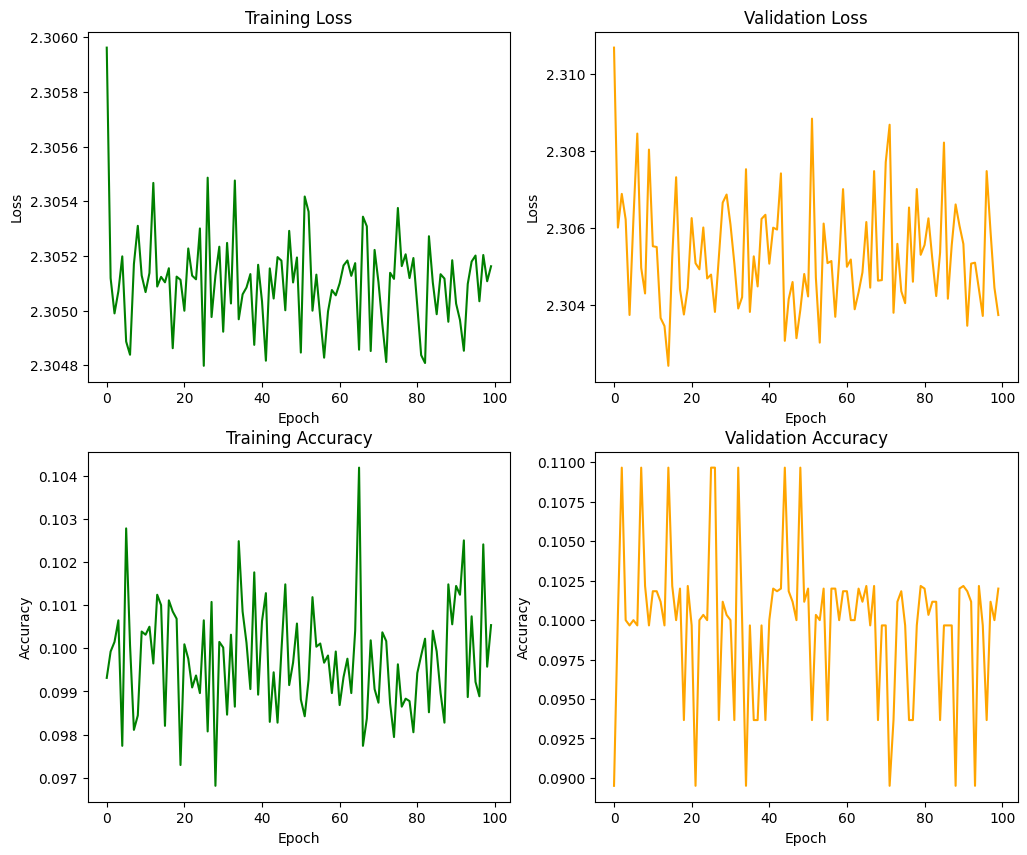

In [30]:
fig, ax = plt.subplots(2, 2, figsize =(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')